# Predicting Perpindiculars

## Setup

In [1]:
from collections import namedtuple
import sympy
from sympy import Matrix, det, symbols, sin, cos, pi
from sympy.physics.units import speed_of_light, meter, second, convert_to, radian
import IPython.display

In [2]:
TrackingWheelCfg = namedtuple('TrackingWheelCfg', ['p', 'theta_rad', 'radius'])

Twist = namedtuple("Twist", ["dx", "dy", "dtheta"])
Pose = namedtuple("Pose", ["x", "y", "theta"])

In [3]:
e_x = Matrix([[1],[0]])
e_y = Matrix([[0],[1]])

In [4]:
def rotation_matrix2d(theta) -> Matrix:
    return Matrix([[cos(theta), -sin(theta)],[sin(theta), cos(theta)]])
    

# Problem

Given Pod Positions $\set{P_1, \cdots, P_n}$ where $P_i = (p_{xi}, p_{yi}, p_{\theta i})$

Imagine the position of a pod on the robot just as a point, not as a wheel

Can imagine that each pod has like the optical tracking sensor on it that can show both x and y motion

Given a $(\Delta x, \Delta y, \Delta \theta)$ of the robot frame, that point will an $(x, y)$ delta

In [5]:
body_twist_to_pod_motion_matrix = Matrix([[1,0,-symbols('p_y')], [0,1,symbols('p_x')]])
body_twist_to_pod_motion_matrix

Matrix([
[1, 0, -p_y],
[0, 1,  p_x]])

Mapping of Robot Motion to sensor Motion `f(robot movement) -> sensor movement`

More specifically, the sensor movement output is the vector containing the x component and y component. The sensor at a point will experience rotations of the robot as movements along a circle

The x and y components are the identity. If you move the pod forward 1 unit without causing the robot to rotate, the robot will will have moved forward one unit

The rotational component is a little trig but im gonna skip that for now bc timelines.

## Rotated Sensors
But, what if our points have a rotation (optical tracking sensor attached at an angle). What we would measure for an x motion for example would register as a y motion if we were rotated by 90 degrees.

To account for this, we rotate our measurements by the rotation of the sensor

In [6]:
body_twist_to_pod_wheel_motion_matrix = rotation_matrix2d(symbols('p_\\theta')) * body_twist_to_pod_motion_matrix
# Vector of [parallel to wheel, perpindicular to wheel]
body_twist_to_pod_wheel_motion_matrix

Matrix([
[cos(p_\theta), -sin(p_\theta), -p_x*sin(p_\theta) - p_y*cos(p_\theta)],
[sin(p_\theta),  cos(p_\theta),  p_x*cos(p_\theta) - p_y*sin(p_\theta)]])

This is effectively the same as before but now we can account for sensors that are not mounted perfectly square with the robot coordinate system.

Still a mapping from Robot movement to sensor movement: `f(robot movement) -> sensor movement`

still the output is the x and y components of the sensors motion.


### Example
if we have three pods $(P_1, P_2, P_3)$, we have a length 6 matrix
gonna call this matrix we've been building up $M$ and the robot motion (dx,dy,dtheta) a vector called T

output = $$M T = \begin{bmatrix}x_1 \\ y_1 \\ x_2 \\ y_2 \\ x_3 \\ y_3\end{bmatrix}$$

where $T = \begin{bmatrix}d_x \\ d_y \\ d_\theta \end{bmatrix}$

and $M$ looks like

In [7]:
M = Matrix([
    body_twist_to_pod_wheel_motion_matrix.subs('p_x', 'p_x1').subs('p_y','p_y1').subs(symbols('p_\\theta'), symbols('p_\\theta1')),
    body_twist_to_pod_wheel_motion_matrix.subs('p_x', 'p_x2').subs('p_y','p_y2').subs(symbols('p_\\theta'), symbols('p_\\theta2')),
    body_twist_to_pod_wheel_motion_matrix.subs('p_x', 'p_x3').subs('p_y','p_y3').subs(symbols('p_\\theta'), symbols('p_\\theta3'))])
M

Matrix([
[cos(p_\theta1), -sin(p_\theta1), -p_x1*sin(p_\theta1) - p_y1*cos(p_\theta1)],
[sin(p_\theta1),  cos(p_\theta1),  p_x1*cos(p_\theta1) - p_y1*sin(p_\theta1)],
[cos(p_\theta2), -sin(p_\theta2), -p_x2*sin(p_\theta2) - p_y2*cos(p_\theta2)],
[sin(p_\theta2),  cos(p_\theta2),  p_x2*cos(p_\theta2) - p_y2*sin(p_\theta2)],
[cos(p_\theta3), -sin(p_\theta3), -p_x3*sin(p_\theta3) - p_y3*cos(p_\theta3)],
[sin(p_\theta3),  cos(p_\theta3),  p_x3*cos(p_\theta3) - p_y3*sin(p_\theta3)]])

This matrix $M$ is a mapping of Robot Motion to perceived motion of 3 sensors.

If we invert the matrix and multiply by the readings of our fictional optical trackers, we should get the Robot Motion back.

## In which we realize we do not have 3 optical tracking sensors and even if we did that would be a waste of them

The bad news is that odometry pods only measure one axis (x-axis of the fictional trackers we've been talking about) while the other axis (y axis) is what causes the rollers to spin and we won't measure anything from that encoder.

The good news is, 6 distance readings is more than enough to solve for 3 degrees of freedom.
And since we can measure half of six with the current robot we're chilling.

Since we will never have data for the 'y-axis' of the fictional sensor, we can drop those rows of our matrix. Which leaves us a 'Reduced' Matrix $M_r$

$M_r$ = 

In [8]:
M_r = Matrix([M.row(i) for i in range(0,M.rows, 2)])
M_r

Matrix([
[cos(p_\theta1), -sin(p_\theta1), -p_x1*sin(p_\theta1) - p_y1*cos(p_\theta1)],
[cos(p_\theta2), -sin(p_\theta2), -p_x2*sin(p_\theta2) - p_y2*cos(p_\theta2)],
[cos(p_\theta3), -sin(p_\theta3), -p_x3*sin(p_\theta3) - p_y3*cos(p_\theta3)]])

Similarly here, we can invert this mapping of robot motion to subset of encoder motion

Then we can feed it the encoders we know and recover the robot motion.

And as a funny side effect if we calculate the robot motion we can then use the non-reduced $M$ to calculate the perpindiclar motion of the omni wheels (this like isnt helpful i don't think but its here)

with T as the robot motion

$$M_r T = E_k = \text{encoders we know}$$

$$M_r^{-1} E_k = T$$

# Example
### Parameters from the software bot

In [9]:
cfg1 = TrackingWheelCfg(Matrix([-0.04445 * meter, 0.06985 * meter]), 0 * radian, 0.028297632 * meter)
cfg2 = TrackingWheelCfg(Matrix([0.008382 * meter, -0.06985 * meter]), pi * radian, 0.028297632 * meter)
cfg3 = TrackingWheelCfg(Matrix([-0.2032 * meter, -0.0127 * meter]), (pi / 2) * radian, 0.028297632 * meter)

$M$ matrix from software bot

In [10]:
MFilled = M \
    .subs(symbols('p_\\theta1'),cfg1.theta_rad / radian) \
    .subs('p_x1', cfg1.p[0] / meter).subs('p_y1', cfg1.p[1] / meter) \
    .subs(symbols('p_\\theta2'),cfg2.theta_rad / radian) \
    .subs('p_x2', cfg2.p[0] / meter).subs('p_y2', cfg2.p[1] / meter) \
    .subs(symbols('p_\\theta3'),cfg3.theta_rad / radian) \
    .subs('p_x3', cfg3.p[0] / meter).subs('p_y3', cfg3.p[1] / meter)
MFilled


Matrix([
[ 1,  0,  -0.06985],
[ 0,  1,  -0.04445],
[-1,  0,  -0.06985],
[ 0, -1, -0.008382],
[ 0, -1,    0.2032],
[ 1,  0,    0.0127]])

$M_r$ from software bot

In [11]:
M_rFilled = Matrix([MFilled.row(r) for r in range(0,MFilled.rows,2)])
M_rFilled

Matrix([
[ 1,  0, -0.06985],
[-1,  0, -0.06985],
[ 0, -1,   0.2032]])

And now, for my final trick, finding the (pseudo)inverse

In [12]:
M_rFilled.pinv()

Matrix([
[              0.5,              -0.5,    0],
[-1.45454545454545, -1.45454545454545, -1.0],
[-7.15819613457409, -7.15819613457409,    0]])

Imagine the robot driving forward 0.01 meters. The forward facing encoders would rotate to make a linear distance of 0.01 meters and the side facing encoder would not rotate(in a direction it can measure at least)

One of the forward facing encoders is reversed becasue of the way it is mounted

$$E_k = \text{encoders we know} = \begin{bmatrix} 0.01 \\ -0.01 \\ 0 \end{bmatrix}$$

In [13]:
T = M_rFilled.pinv()*Matrix([0.01, -0.01, 0])
T

Matrix([
[0.01],
[   0],
[   0]])

Would you look at that, a forward motion.

Now if we wanna extrapolate what the perpindicular, unmeasurable movements of the omni wheels was we can do that too

In [14]:
MFilled * T

Matrix([
[ 0.01],
[    0],
[-0.01],
[    0],
[    0],
[ 0.01]])

Final note, the angular motion to linear motion of the omni wheel is not included here.

You can add it in when making the known encoder vector. Or you can probably put it in sooner i just didnt do that

In [15]:
import random

In [16]:
(random.random() * 2 - 1) * 0.1

0.07928003371843095

In [17]:
M_rFilled.pinv()

Matrix([
[              0.5,              -0.5,    0],
[-1.45454545454545, -1.45454545454545, -1.0],
[-7.15819613457409, -7.15819613457409,    0]])

In [18]:
M_rFilled.pinv() * Matrix([0,0,0.1])

Matrix([
[   0],
[-0.1],
[   0]])

In [19]:
inverse = M_rFilled.pinv()
pos = Matrix([0,0,0])
poss = [pos]
for i in range(4000):

    delt = inverse * Matrix([0.002,0.002, 0.0])
    pdelt = rotation_matrix2d(pos[2]) * Matrix([delt[0],delt[1]]) 
    delt[0] = pdelt[0]
    delt[1] = pdelt[1]

    pos += delt 
    poss.append(pos)

In [20]:
import matplotlib.pyplot as plt

In [21]:
import pandas as pd

In [22]:
df = pd.read_csv('encoderdeltas.csv', names=(["left", "right", "rear"]))
df['t'] = df.index
df['left'] = pd.to_numeric(df['left'], errors='coerce')
df['right'] = pd.to_numeric(df['right'], errors='coerce')
df['rear'] = pd.to_numeric(df['rear'], errors='coerce')
df = df.dropna()

In [119]:
inverse = M_rFilled.pinv()
pos = Matrix([0,0,0])
posex = []
posey = []
poseo = []

deltx = []
delty = []
delto = []

for i, row in df.iterrows():
    E_k = Matrix([row['left'], row['right'], row['rear']])
    delt = inverse * E_k

    pdelt = rotation_matrix2d(pos[2]) * Matrix([delt[0],delt[1]]) 
    delt[0] = pdelt[0]
    delt[1] = pdelt[1]
    
    delt[2] = delt[2] / 2

    pos += delt 
    deltx.append(delt[0])
    delty.append(delt[1])
    delto.append(delt[2])

    posex.append(pos[0])
    posey.append(pos[1])
    poseo.append(pos[2])

In [120]:
df['twistx'] = deltx
df['twisty'] = delty
df['twisto'] = delto

df['twistx'] = df['twistx'].astype(float)
df['twisty'] = df['twisty'].astype(float)
df['twisto'] = df['twisto'].astype(float)


df['posex'] = posex
df['posey'] = posey
df['poseo'] = poseo

df['posex'] = df['posex'].astype(float)
df['posey'] = df['posey'].astype(float)
df['poseo'] = df['poseo'].astype(float)


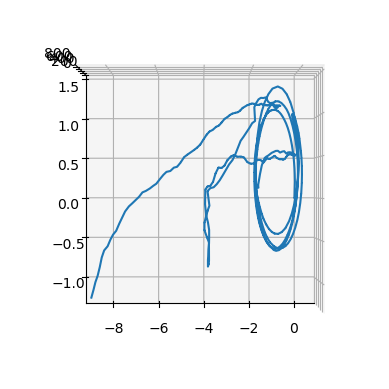

In [121]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(df['posex'], df['posey'], zs=df['t'], zdir='z', label='curve in (x, y)')
ax.view_init(elev=90., azim=-90, roll=0)


<Axes: xlabel='t'>

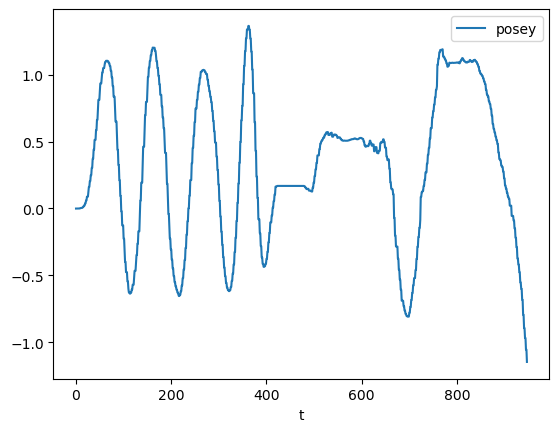

In [122]:
df.plot(x='t', y='posey')

In [123]:
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.patches as patches

IndexError: single positional indexer is out-of-bounds

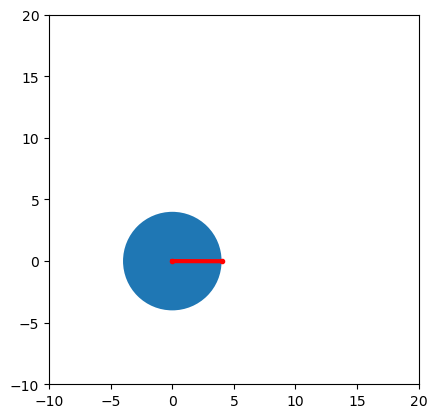

In [124]:
figure, ax = plt.subplots()

# Setting limits for x and y axis
ax.set_xlim(-10, 20)
ax.set_ylim(-10, 20)

# Since plotting a single graph
radius = 4
rect  = patches.Circle((6,6), radius)

def orientationLine(x, y, angle_rad):
    dx = cos(angle_rad) * radius
    dy = sin(angle_rad) * radius
    return [x, x+dx], [y, y+dy]

ax.add_patch(rect)

line, = ax.plot([0], [0], marker='o', markersize=3, c ='r', linewidth=3)

ax.set_aspect('equal')

def animation_function(i):
    row = df.iloc[i]
    rect.center = (row['posex'], row['posey'])

    xd, yd = orientationLine(row['posex'], row['posey'], row['poseo'])
    line.set_xdata(xd)
    line.set_ydata(yd)
    return rect

animation = FuncAnimation(figure,
                          func = animation_function,
                          frames = np.arange(df.index.min(), df.index.max()-10, 2), 
                          interval = 16)
animation.save("out.mp4")


In [ ]:
plt.close()